# Deep Vision Projekt - Paper Group Normalization (Marco Deuscher)

In [1]:
LOCAL = True

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms
import time, datetime, os

from tqdm import tqdm

model_root_dir = ""
if not LOCAL:
    model_root_dir = "/content/gdrive/MyDrive/DVExam/"
    from google.colab import drive
    drive.mount("/content/gdrive")


print("GPU available:", torch.cuda.is_available())
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Device used:", device)

%load_ext tensorboard

GPU available: True
Device used: cuda:0


## Datasets

Files already downloaded and verified
Data-shape: torch.Size([10, 3, 32, 32]) - Label-shape: torch.Size([10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

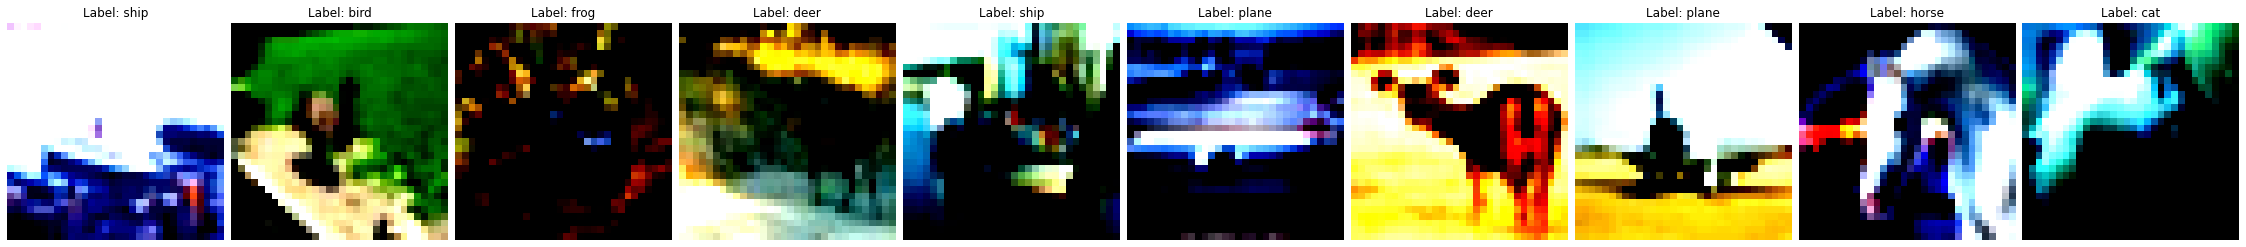

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from src.util.DataLoader import getCIFARLoader, CLASSES_CIFAR10

loader = getCIFARLoader(train=True, batch_size=10)
data, label = next(iter(loader))
print(f"Data-shape: {data.shape} - Label-shape: {label.shape}")

fig = plt.figure(figsize=(40., 40.))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(1, 10),  
                 axes_pad=0.1)


for idx, ax in enumerate(grid):
  ax.imshow(data[idx].permute([1, 2, 0]))
  ax.axis("off")
  ax.set_title(f"Label: {CLASSES_CIFAR10[label[idx]]}")

plt.savefig("//home/marco/Downloads/CIFAR.png")

Data-shape: torch.Size([10, 1, 28, 28]) - Label-shape: torch.Size([10])


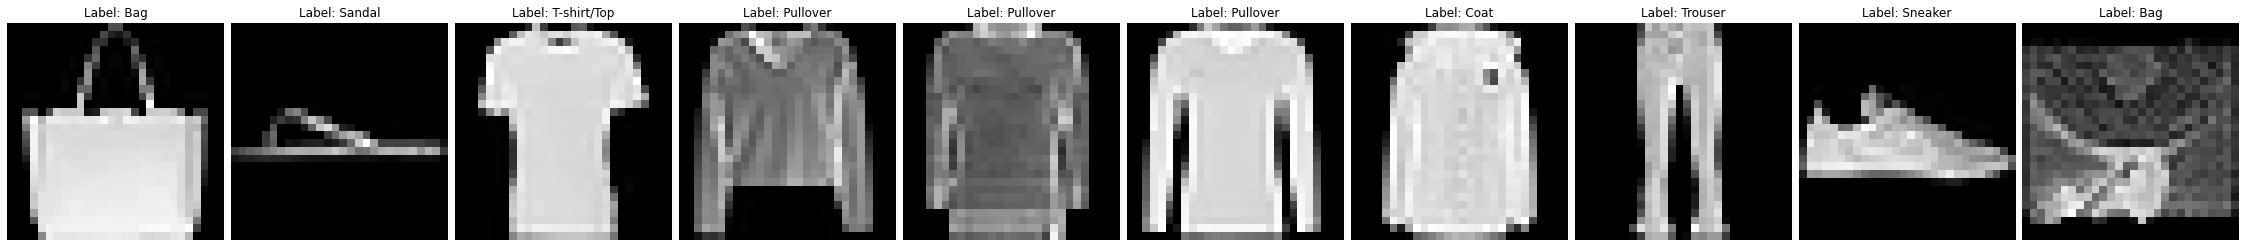

In [4]:
from src.util.DataLoader import getFashionMNISTLoader, CLASSES_FASHIONMNIST

loader = getFashionMNISTLoader(train=True, batch_size=10)
data, label = next(iter(loader))
print(f"Data-shape: {data.shape} - Label-shape: {label.shape}")


fig = plt.figure(figsize=(40., 40.))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(1, 10),  
                 axes_pad=0.1)

for idx, ax in enumerate(grid):
  ax.imshow(data[idx].squeeze(0), cmap="gray")
  ax.axis("off")
  ax.set_title(f"Label: {CLASSES_FASHIONMNIST[label[idx]]}")

plt.savefig("//home/marco/Downloads/MNIST.png")

## Training

In [5]:
%tensorboard --logdir runs

Launching TensorBoard...

In [6]:
from src.train import train_network

train_network(epochs=200, batch_size=16, group_norm=False, dataset="CIFAR10")

TypeError: train_network() missing 1 required positional argument: 'device'

## Evaluation

In [27]:
from src.eval import model_eval
from src.model.SimpleNet import SimpleNetv2
from src.model.ResNet import ResNet34

bs_list = [64, 32, 16, 8, 4, 2]
norm_list = ["BN", "GN"]

results = {"BN": [], "GN": []}

for norm in norm_list:
    for bs in bs_list:
        acc = model_eval(f"model/epochs30-bs{bs}-{norm}-dsCIFAR10.pth", device, dataset="CIFAR10", group_norm=(norm=="GN"), modelClass=SimpleNetv2)
        results[norm].append(100.0 - acc)

resnet_baseline = model_eval("model/resnet34-epochs200-bs128-BN.pth", device, "CIFAR10", batch_size=128, group_norm=False, modelClass=ResNet34)

Files already downloaded and verified


100%|██████████| 79/79 [00:00<00:00, 85.26it/s]


Files already downloaded and verified


100%|██████████| 79/79 [00:00<00:00, 87.80it/s] 


Files already downloaded and verified


100%|██████████| 79/79 [00:00<00:00, 85.12it/s]


Files already downloaded and verified


100%|██████████| 79/79 [00:00<00:00, 87.42it/s] 


Files already downloaded and verified


100%|██████████| 79/79 [00:00<00:00, 80.74it/s]


Files already downloaded and verified


100%|██████████| 79/79 [00:00<00:00, 84.71it/s]


Files already downloaded and verified


100%|██████████| 79/79 [00:00<00:00, 88.20it/s] 


Files already downloaded and verified


100%|██████████| 79/79 [00:00<00:00, 86.10it/s] 


Files already downloaded and verified


100%|██████████| 79/79 [00:00<00:00, 83.98it/s]


Files already downloaded and verified


100%|██████████| 79/79 [00:00<00:00, 84.59it/s]


Files already downloaded and verified


100%|██████████| 79/79 [00:00<00:00, 83.67it/s]


Files already downloaded and verified


100%|██████████| 79/79 [00:00<00:00, 82.87it/s]


Files already downloaded and verified


100%|██████████| 79/79 [00:04<00:00, 17.76it/s]


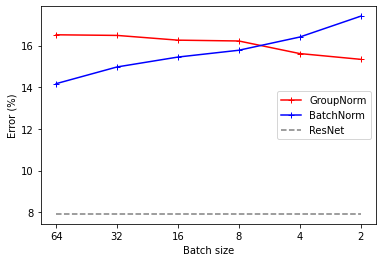

In [26]:
values = range(len(bs_list))
plt.plot(values, results["GN"], c="red", marker="+")
plt.plot(values, results["BN"], c="blue", marker="+")
plt.plot(values, [100.0 - resnet_baseline] * len(bs_list), "--", c="gray")
plt.xticks(values, bs_list)
plt.legend(["GroupNorm", "BatchNorm", "ResNet"])
plt.axis("on")
plt.ylabel("Error (%)")
plt.xlabel("Batch size")
plt.savefig("/home/marco/Downloads/plot.png")
